## Deep Learning Meets Hyperspectral Image Analysis

### Abstract

 Modern hyperspectral imaging systems produce huge datasets potentially conveying a great abundance of information.
 such a resource, however, poses many challenges in the analysis and interpretation of these data.
 In recent decades, a rapid increase in production of oilseed
rape has required the improvement of fertilizer management to optimize
the crop yield and product quality. Rapid detection of nitrogen (N)
concentration in oilseed rape leaf during the growing season is essential
to accurately manage the nitrogen fertilizer applications, which have
great benefits in improving yield and quality of the oilseed rape crop.
 Deep learning approaches certainly offer a great variety of opportunities for solving classical imaging tasks and also for approaching new stimulating problems in the spatial–spectral domain.

### Introduction

Deep-learning-based regression model composed of stacked auto-encoders (SAE) and fully-connected neural
network (FNN) was used for the detection and quantification of nitrogen (N) concentration in oilseed rape leaf.
SAE was applied to extract deep spectral features from visible and near-infrared hyperspectral
image of oilseed rape leaf, and then these features were used as input data for FNN to predict N concentration.

In this study, a
deep-learning-based regression model composed of stacked
auto-encoders (SAE)  and simple fully-connected neural network
(FNN) is proposed for the detection of N concentration in oilseed rape
leaf. The SAE is trained on pixel spectra in an unsupervised manner to
automatically learn deep spectral features from hyperspectral image, and
the deep spectral features are fed to the FNN to quantitatively predict the
corresponding N concentration in a supervised manner.

### Workflow

#### Load packages


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import six.moves.cPickle as pickle
import gzip
import pandas as pd
import matplotlib.ticker as ticker
from keras.layers.advanced_activations import LeakyReLU
import talos as ta
import wrangle as wr
from talos.metrics.keras_metrics import fmeasure_acc
from talos import live
# Keras items
from keras.optimizers import Adam, Nadam
from keras.activations import relu, elu
from keras.losses import binary_crossentropy
from keras.layers import Input, Dense,Dropout
from keras.models import Model, Sequential, save_model, load_model
from keras.callbacks import CSVLogger,ModelCheckpoint
%matplotlib inline
from keras.models import Model
from sklearn.model_selection import train_test_split
import sys
from pandas.core import datetools
from numpy.core.umath_tests import inner1d
from talos.utils.gpu_utils import multi_gpu
from talos.utils.gpu_utils import force_cpu
sys.path.insert(0, '/home/ubuntu/talos/')
import talos as ta
from sklearn.metrics import mean_squared_error, r2_score
import random
random.seed(100) # for reproducibility
def rmse(predictions, targets): #RMSE function for model evaluation
    return np.sqrt(((predictions - targets) ** 2).mean())

### Load data

In [2]:
###########################################################################################################
#Parameters
###########################################################################################################

train_dataset="/home/ubuntu/SAE-FNN_Code_Data/data/train_pixels/ramdonpixel_train.pkl.gz"   #train dataset 
validation_dataset="/home/ubuntu/SAE-FNN_Code_Data/data/train_pixels/ramdonpixel_val.pkl.gz"#validation dataset
meanspectrumdataset="/home/ubuntu/SAE-FNN_Code_Data/data/Meanspectra.csv"                   #Mean spectra for each sample in both calibration and testing set


### Data describtion

For each sample-nitrogen concentration, spectral data in the
range of 380–1030 nm wavelength with 512 bands of each pixel were taken.

In [3]:
with gzip.open(train_dataset, 'rb') as f:
            train_set1, valid_set1 = pickle.load(f)
with gzip.open(validation_dataset, 'rb') as f:
            train_set2, valid_set2= pickle.load(f)
X=np.concatenate((train_set1[0],train_set2[0],valid_set1[0],valid_set2[0]))
y=np.concatenate((train_set1[1],train_set2[1],valid_set1[1],valid_set2[1]))


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, shuffle=True )

### Data visualization

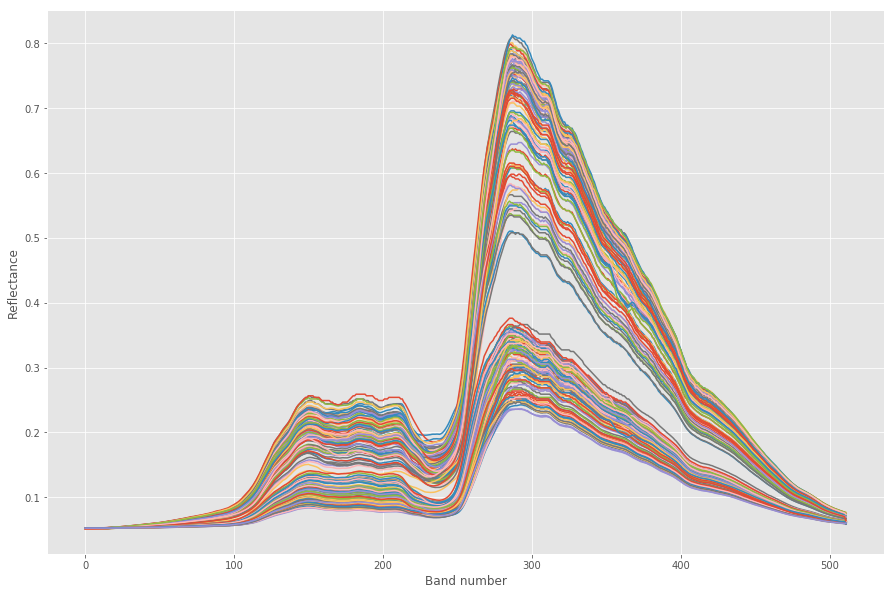

In [5]:
data = pd.read_csv("/home/ubuntu/SAE-FNN_Code_Data/data/Meanspectra.csv")
y=data.iloc[:, 2]
X=data.iloc[:, 3:]
band=range(512)
# Plot spectra
plt.figure(figsize=(15,10))
with plt.style.context(('ggplot')):
    plt.plot(band, X.T)
    plt.xlabel('Band number')
    plt.ylabel('Reflectance')    
plt.show()

### Model defintion
- The sequential API allows as to create models layer-by-layer.
- This is simply a linear stack of neural network layers.

In [6]:
# input: train (70%) and validation (30%) data with grid of paramaters (p)
# output: compiled model and model's data
def model_opti(x_train, y_train, x_val, y_val, params):
    
    #model format
    model = Sequential()
    
    #input layer
    model.add(Dense(params['first_neuron'],
                    input_dim=x_train.shape[1],
                    #this line is used to convey the fact that we wish to tune the activation 
                    #function parameter and find the best fit among 
                    activation=params['activation'],
                    #this line is used to convey the fact that we wish to tune the 
                    #kernel initializer parameter and find the best fit among 
                    kernel_initializer=params['kernel_initializer']))  
    #adding more layers
    #this line is used to convey the fact that we wish to tune the value of the keep probability of 
    #Dropout and find the best fit among the range of real numbers between 0 and 1.(=0)
    model.add(Dropout(params['dropout']))
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer']))
    
    #compiling the model
    #we declare the loss function and the optimizer
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'](),
                  metrics=['acc', fmeasure_acc])
    
    #fitting the model on training data
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        callbacks=[live()],
                        epochs=params['epochs'],
                        verbose=0)

    return history, model

### Tuning hyperparamters
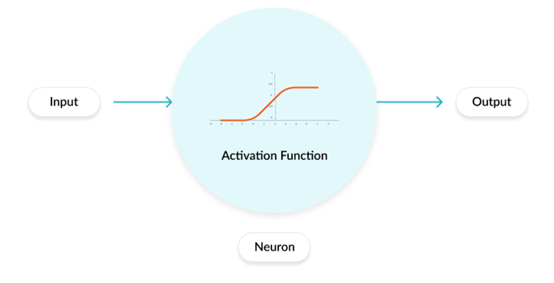

- hidden_layers:Layer in between input layers and output layers, where artificial neurons take in a set of weighted inputs and produce an output through an activation function.
- batch_size: number of patterns shown to the network before the weight matrix is updated. If batch size is less, patterns would be less repeating and hence the weights would be all over the place and convergence would become difficult. If batch size is high learning would become slow as only after many iterations will the batch size change.
- epochs: The number of epochs is the number of times the entire training data is shown to the model. It plays an important role in how well does the model fit on the train data. High number of epochs may over-fit to the data and may have generalization problems on the test and validation set, also they could cause vanishing and exploding gradient problems.





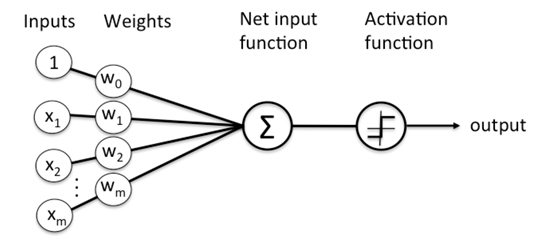
- dropout:The keep-probability of the Dropout layer.
- kernel_initializer: - Doesn’t play a very big role but still it is preferred to use normal/uniform initialization while using ReLUs.
- optimizer: It is the algorithm used by the model to update weights of every layer after every iteration. 
- losses: we seek to minimize the error. As such, the objective function is often referred to as a cost function or a loss function and the value calculated by the loss function.

In order to "sense" the best parameters we cahnged the grid range couple of times til we got this practical grid.

presumption that was used: the more epochs the better, until overfiting. hence we used a small value in the tuning section, in the final model we used larger value.

In [7]:
# set the parameter space
p =  {'first_neuron':[7,8,9,10,20],
     'hidden_layers':[3,4,5,10],
     'batch_size': [128],
     'epochs': [20],
     'dropout': [0.5,0.6,0.7,0.8],
     'kernel_initializer': ['normal','uniform'],
     'optimizer': [ Adam],
     'losses': ['mean_squared_error'],
     'activation':[elu,relu],
     'last_activation': ['elu','relu']
}

#### Hyperparameter tuning
Talos package provides a fully automated POD (Prepare, Optimize, Deploy) pipeline.

We will activate the model based on the parameters and the layer configuration above.

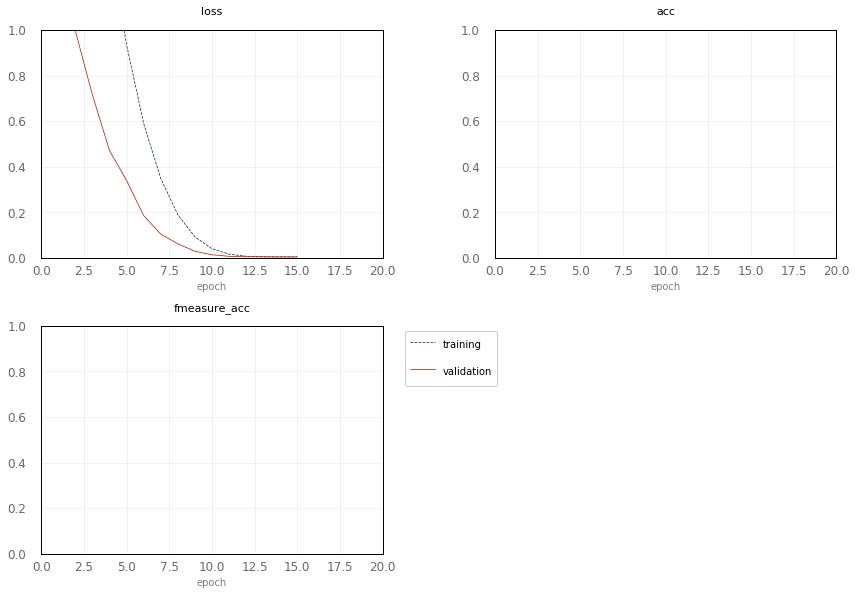

In [ ]:
#input: train set, model settings, hyperparamaters grid
#output: csv file with all combinations.
force_cpu()
t = ta.Scan(x=X_train,
            y=y_train,
            model=model_opti,
            params=p,
            dataset_name='talos tutorial',
            experiment_no='1')

Best hyperparametrs by MSE, that found by Talos optimization:

In [ ]:
r = ta.Reporting(t)
# get the best paramaters
print(r.best_params())

Using the best hyperparametrs with large epoch number, in order to fine tune the model

In [41]:
# set the parameter space
p2 =  {'first_neuron':[8],
     'hidden_layers':[5],
     'batch_size': [128],
     'epochs': [11000],
     'dropout': [0.5],
     'kernel_initializer': ['normal'],
     'optimizer': [ Adam],
     'losses': ['mean_squared_error'],
     'activation':[elu],
     'last_activation': ['elu']
}

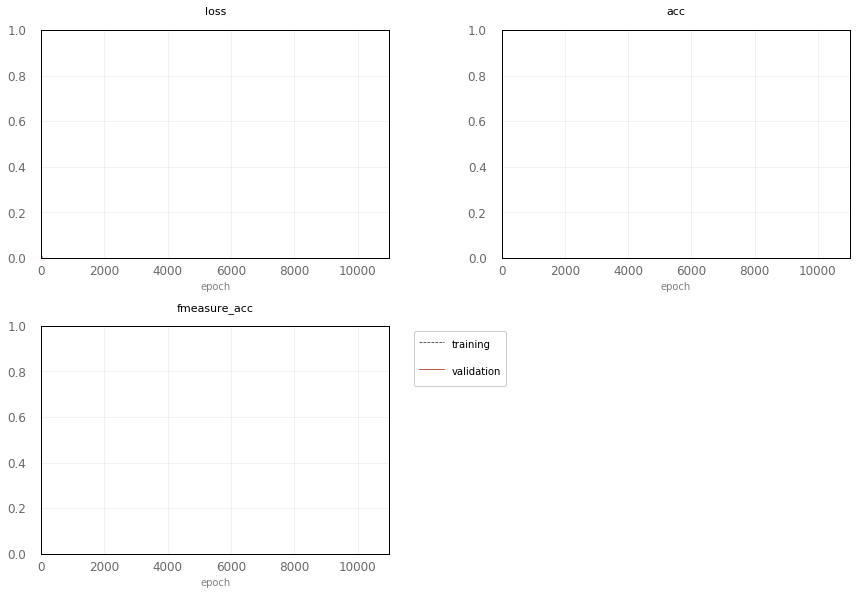

In [ ]:
#input: train set, model settings, hyperparamaters grid
#output: csv file with final combination.
force_cpu()
t = ta.Scan(x=X_train,
            y=y_train,
            model=model_opti,
            params=p2,
            dataset_name='talos tutorial',
            experiment_no='pred')

Extra Talos options:

In [43]:
# accessing the results data frame
#print(t.data.head())
# accessing the saved weights for models
#print(t.saved_weights)
# use Scan object as input
# accessing the saved models
#t.saved_models


,round_epochs,val_loss,val_acc,val_fmeasure_acc,loss,acc,fmeasure_acc,first_neuron,hidden_layers,batch_size,epochs,dropout,kernel_initializer,optimizer,losses,activation,last_activation
0,11000,0.001192,0.0,1.0,0.001809,0.0,1.003093,8,5,128,11000,0.5,normal,<class 'keras.optimizers.Adam'>,mean_squared_error,<function elu at 0x7facf535cae8>,elu


Finally we used the SAE model in order to predict the test set.

In [48]:
ta.Deploy(t, 'SAE1')
SAE1 = ta.Restore('SAE1.zip')
pred=SAE1.model.predict(X_test)

Deploy package SAE1 have been saved.


Predication results

In [49]:
rmse_val = rmse(y_test, pred)       #RMSEP
r2_val = r2_score(y_test, pred)     #R2P
RPDp=np.std(y_test)/rmse_val*1.0    #RPDp

print(" prediction r2 is: " + str(r2_val))
print(" prediction rms error is: " + str(rmse_val))
print(" prediction RPDp is: " + str(RPDp))

 prediction r2 is: 0.7526228339979012
 prediction rms error is: 0.03451115359291276
 prediction RPDp is: 2.0105746155044133


### Conclusions

#### The results of this study demonstrate that deep learning was feasible to be used as Hyperspectral imaging data analysis method for N prediction in oilseed rape leaf. 
#### $R^2$ = 0.752 (Paper result: 0.903)
#### Rmse = 0.0345 (Paper result: 0.307)
#### RPDp = 2.0105 (Paper result: 3.238)

In [51]:

###########################################################################################################
#Load Dataset.
###########################################################################################################
Meanspectrums = pd.read_csv(meanspectrumdataset,header=0)
x=np.array(Meanspectrums)[:,3:515]   # 512 bands of mean spectra
y=np.array(Meanspectrums)[:,2:3]     # N content label

#Divided into calibration and testing set
calibration_x=x[np.where(np.array(Meanspectrums)[:,1] == 1)] # Get 128 mean spectra,calibration_x, dataset value=1
calibration_y=y[np.where(np.array(Meanspectrums)[:,1] == 1)] # Get 128 N content, calibration_y 
testing_x=x[np.where(np.array(Meanspectrums)[:,1] == 0)]     # Get 64 mean spectra, testing_x, dataset value=0
testing_y=y[np.where(np.array(Meanspectrums)[:,1] == 0)]     # Get 64 N content,testing_y



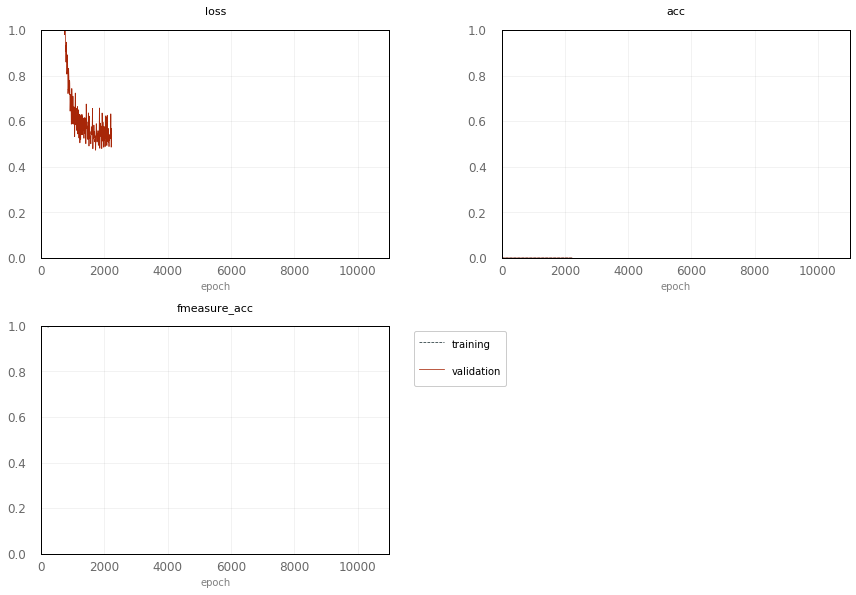

In [ ]:
#input: meanspectra train set, model settings, hyperparamaters grid
#output: csv file with all combinations.
force_cpu()
t = ta.Scan(x=calibration_x,
            y=calibration_y,
            model=model_opti,
            params=p2,
            dataset_name='talos tutorial',
            experiment_no='1_mean')

In [56]:
ta.Deploy(t, 'SAE2')
SAE2 = ta.Restore('SAE2.zip')
pred=SAE2.model.predict(X_test)

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7faca0d61e80>>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 94788910440352


Deploy package SAE2 have been saved.


In [57]:
pred=SAE2.model.predict(testing_x)
rmse_val = rmse(testing_y, pred)       #RMSEP
r2_val = r2_score(testing_y, pred)     #R2P
RPDp=np.std(testing_y)/rmse_val*1.0    #RPDp

print(" prediction r2 is: " + str(r2_val))
print(" prediction rms error is: " + str(rmse_val))
print(" prediction RPDp is: " + str(RPDp))

 prediction r2 is: 0.6858270068168486
 prediction rms error is: 0.5530388272351022
 prediction RPDp is: 1.7840851369752933
